# To do:
- add distanceM column to WWLLN
- get longer time period for WWLLN (request to Bob Holz directly?)
- spatially filter both datasets & plot to detect timing better

In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from obspy import UTCDateTime
from datetime import datetime 
DATA_DIR = os.path.join(os.getenv('HOME'), 'DATA', 'Tonga_eruption_analysis')

In [208]:
from obspy.geodetics import locations2degrees, degrees2kilometers
sourcelat = -20.536
sourcelon = -175.382 
def add_distanceM_column(df):
    if not 'distanceM' in df.columns:
        df['distanceM'] = [degrees2kilometers(locations2degrees(lat, lon, sourcelat, sourcelon))*1000 for lat,lon in zip(df['latitude'],df['longitude'])]
        
def add_CountsPerMinute_column(dfin):
    #dfin.sort_values(by='datetime',inplace=True)
    df = pd.DataFrame()
    df['ones']=dfin['ones']
    df['datetime'] = dfin.datetime
    #df.set_index('datetime', inplace=True)
    countsPerMin = df.rolling('10s',on='datetime').sum()
    #print(countsPerMin)
    dfin['CountsPerMinute'] = countsPerMin['ones']
    #df.reset_index(inplace=True)
    #fin['CountsPerMinute']=df['countsPerMin']
    
# plot WWLLN data
def plot_wwlln(df, starttime='1900-01-01', endtime='2100-01-01', radiusM=12500000, y_columns = ['cum_events', 'cum_detections', 'CountsPerMinute']):    
    for ycol in y_columns:
        if not ycol in df.columns:
            if not ycol == 'CountsPerMinute':
                y_columns.remove(ycol)
    df2 = df.loc[(df['datetime'] >= starttime)
            & (df['datetime'] < endtime) & df['distanceM'] < radiusM]       
    #fig, ax = plt.subplots(len(y_columns),1)
    linestyle='k.'
    add_CountsPerMinute_column(df2) # needs redoing after filtering
    fig = plt.figure(figsize=(12, 4))
    ax=[]
    #fig, ax = plt.subplots(len(y_columns),1)
    for i in range(len(y_columns)):
        ax.append(fig.add_subplot(len(y_columns), 1, i+1))
        #ax[i] = df2.plot.scatter(x='datetime', y=y_columns[i], c='DarkBlue', marker='.')
        ax[i].plot_date(df2['datetime'], df2[y_columns[i]], linestyle)
        ax[i].set_ylabel(y_columns[i])
        xtl = ax[i].get_xticklabels()
        plt.setp(xtl, rotation=45)
        if starttime:
            ax[i].set_xlim(starttime, endtime)
            
#import matplotlib.dates as mdates 
def plot_gld360(df, starttime='1900-01-01', endtime='2100-01-01', lightning_type=None, radiusM=12500000, y_columns = ['cum_events', 'signalStrengthKA', 'weightedCurrent', 'CountsPerMinute']):
    for ycol in y_columns:
        if not ycol in df.columns:
            if not ycol == 'CountsPerMinute':
                y_columns.remove(ycol)
    df2 = df.loc[(df['datetime'] >= starttime)
            & (df['datetime'] < endtime) & (df['distanceM'] < radiusM)] 

    linestyle = 'b.'
    if lightning_type:
        if lightning_type == 'cloud2cloud':
            df2 = df2.loc[df2['cloud']==True]
            linestyle = 'g.'
        elif lightning_type == 'cloud2ground':
            df2 = df2.loc[df2['cloud']==False]
            linestyle = 'r.'
            
    df2['cum_events'] = np.cumsum(df2['ones'])
    add_CountsPerMinute_column(df2)  # needs redoing after filtering
    
    st = obspy.Stream()
    fig = plt.figure(figsize=(12, 4))
    ax=[]
    #fig, ax = plt.subplots(len(y_columns),1)
    for i in range(len(y_columns)):
        ax.append(fig.add_subplot(len(y_columns), 1, i+1))
        #ax[i] = df2.plot.scatter(x='datetime', y=y_columns[i], c='DarkBlue', marker='.')
        ax[i].plot_date(df2['datetime'], df2[y_columns[i]], linestyle)
        ax[i].set_ylabel(y_columns[i])
        xtl = ax[i].get_xticklabels()
        plt.setp(xtl, rotation=45)
        #ax[i].xaxis.set_major_locator(mdates.DayLocator(interval=4))
        #ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%b\n%d'))
        if starttime:
            ax[i].set_xlim(starttime, endtime)  
        tr = obspy.Trace() 
        tr.data = 
    # turn into 
    return df2['datetime'],

In [193]:
# Load WWLLN data
# I got these data from Steve McNutt (email on March 1st) who got them from Bob Holzworth at UW (bobholz@uw.edu)
# Cite: Dowden, Brundell, Rodger, Source [2002], J. Atmos. 
# Parameters Steve asked for were -24 to -18 lat, -179 to -172 lon, 0400 to 1600 UTC
# residual is fit residual in microseconds
# I should add a distanceM column from -20.536, -175.382 as for the GLD360 data
wwllndatafile = os.path.join(DATA_DIR, 'A20220115.HungaTonga.loc')
wwllndf = pd.read_csv(wwllndatafile, names=['date', 'time', 'latitude', 'longitude', 'residual', 'num_stations'])

# Create a datetime column
timestamp = []
for i,row in wwllndf.iterrows():
    this_timestr = row['date'].replace('/','-')+'T'
    this_timestamp = UTCDateTime(this_timestr + row['time']).datetime
    timestamp.append(this_timestamp)
wwllndf['datetime']=timestamp    
wwllndf.sort_values(by='datetime',inplace=True)

# Add other columns for plotting purposes
wwllndf['ones']=np.ones(len(wwllndf['datetime']))
wwllndf['cum_events']=np.cumsum(wwllndf['ones'])
wwllndf['cum_detections']=np.cumsum(wwllndf['num_stations'])
                        
add_distanceM_column(wwllndf) 
#add_CountsPerMinute_column(wwllndf)   

In [194]:
# Load Vaisala GLD360 data
# contact is chris.vagasky@vaisala.com, see email from March 3, 2022
# distanceM is from -20.536, -175.382. 
gld360datafile = os.path.join(DATA_DIR, 'Hunga_Tonga_Lightning_within_300km_December-January.csv')
gld360df = pd.read_csv(gld360datafile)

# Create a datetime column
gld360df['datetime'] = [UTCDateTime(dt).datetime for dt in gld360df['time']]
gld360df.sort_values(by='datetime',inplace=True)

# Add other columns for plotting purposes - do not add cumulative columns unless i subset later
gld360df['ones']=np.ones(len(gld360df['datetime']))

weightedCurrent = []
for i, row in gld360df.iterrows():
    try:
        weightedCurrent.append(row['signalStrengthKA']/row['distanceM'])
    except:
        pass

gld360df['weightedCurrent'] = weightedCurrent       

add_distanceM_column(gld360df) 
#add_CountsPerMinute_column(gld360df)  

/home/thompsong/anaconda3/envs/nexus/lib/python3.6/site-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/thompsong/anaconda3/envs/nexus/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


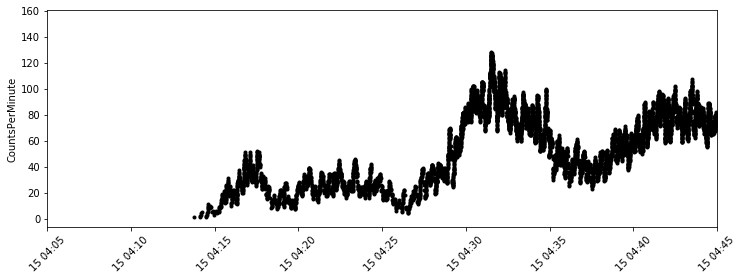

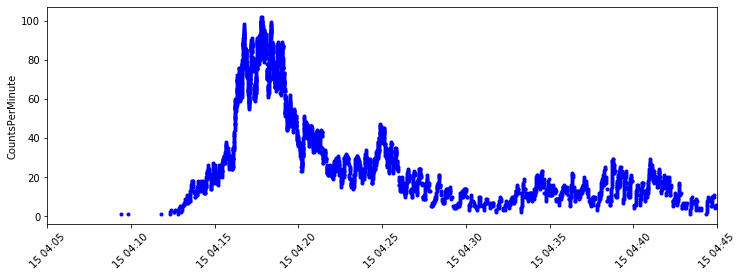

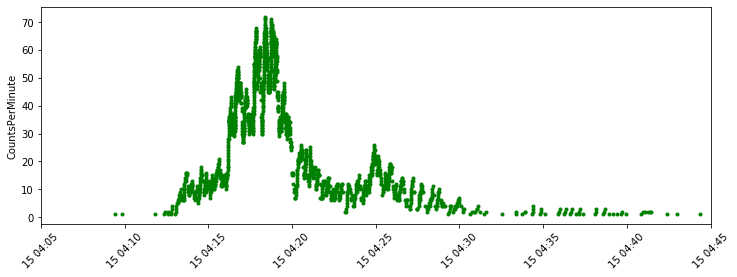

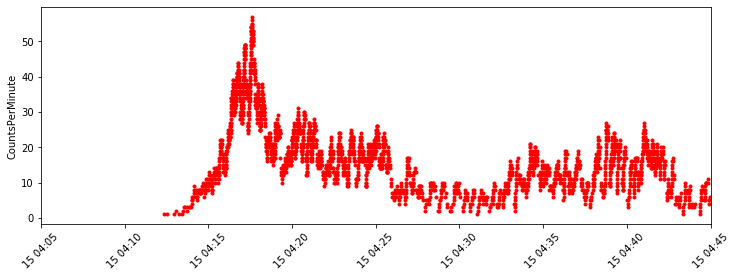

In [215]:
#add_CountsPerMinute_column(wwllndf)  
#add_CountsPerMinute_column(gld360df) 
stime = '2022-01-15 04:05:00'
#etime = '2022-01-15 16:00:00'
etime = '2022-01-15 04:45:00'
maxDistance = 10000.0
ycols = ['CountsPerMinute'] #, 'CountsPerMinute']
plot_wwlln(wwllndf, starttime=stime, endtime=etime, radiusM=maxDistance, y_columns=ycols )
plot_gld360(gld360df, starttime=stime, endtime=etime, radiusM=maxDistance, y_columns=ycols)
plot_gld360(gld360df, lightning_type='cloud2cloud', starttime=stime, endtime=etime, radiusM=maxDistance,  y_columns=ycols)
plot_gld360(gld360df, lightning_type='cloud2ground', starttime=stime, endtime=etime, radiusM=maxDistance,  y_columns=ycols)

In [205]:
wwllnf = wwllndf.loc[(wwllndf['datetime'] >= '2022-01-15 04:00:00') & (wwllndf['datetime'] < '2022-01-15 05:00:00')]
wwllnf.head(500)

,date,time,latitude,longitude,residual,num_stations,datetime,ones,cum_events,cum_detections,distanceM
0,2022/01/15,04:13:46.280020,-20.4972,-175.3838,15.0,11,2022-01-15 04:13:46.280020,1.0,1.0,11,4318.433624
1,2022/01/15,04:14:08.875690,-20.6493,-175.7936,10.9,6,2022-01-15 04:14:08.875690,1.0,2.0,17,44657.377054
2,2022/01/15,04:14:08.875776,-20.6043,-175.5074,11.6,6,2022-01-15 04:14:08.875776,1.0,3.0,23,15103.194952
3,2022/01/15,04:14:10.552570,-20.5506,-175.4505,10.9,5,2022-01-15 04:14:10.552570,1.0,4.0,28,7314.901835
4,2022/01/15,04:14:10.552614,-20.5667,-175.2536,18.3,9,2022-01-15 04:14:10.552614,1.0,5.0,37,13797.739062
...,...,...,...,...,...,...,...,...,...,...,...
495,2022/01/15,04:18:07.778085,-20.6627,-175.4749,5.3,6,2022-01-15 04:18:07.778085,1.0,496.0,4122,17087.509101
496,2022/01/15,04:18:07.778140,-20.6424,-175.3179,12.8,8,2022-01-15 04:18:07.778140,1.0,497.0,4130,13582.922709
497,2022/01/15,04:18:09.125271,-20.5543,-175.4127,20.9,13,2022-01-15 04:18:09.125271,1.0,498.0,4143,3789.284925
498,2022/01/15,04:18:09.125309,-20.5619,-175.3262,21.6,5,2022-01-15 04:18:09.125309,1.0,499.0,4148,6484.514008


In [218]:
wwllnf.loc[0,'datetime']

Timestamp('2022-01-15 04:13:46.280020')

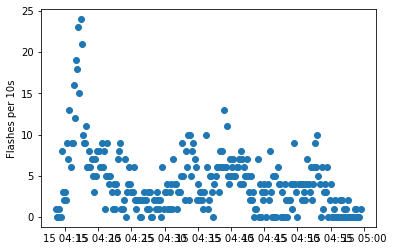

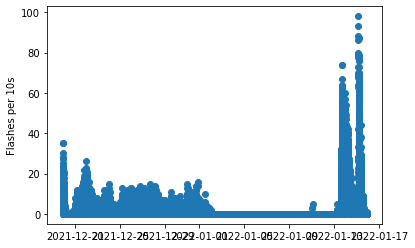

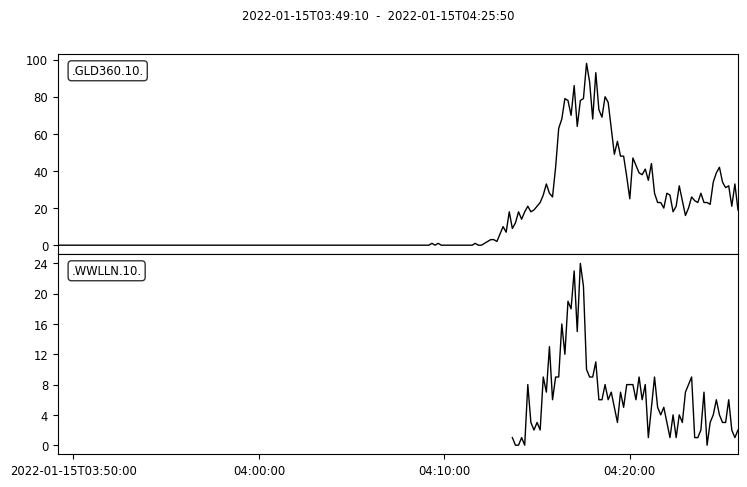

Exception: Unsupported data type int64 in Stream[0].data

In [234]:
import obspy
st = obspy.Stream()
radiusM = 10000

df2 = wwllnf.loc[ (wwllnf['distanceM'] < radiusM)] 
wwllnf2=df2.set_index('datetime')
wwlln_hist = wwllnf2.resample('10s').count()
fig, ax = plt.subplots(1,1)
ax.plot_date(wwlln_hist.index, wwlln_hist.ones)
ax.set_ylabel('Flashes per 10s')

df3 = gld360df.loc[ (gld360df['distanceM'] < radiusM)] 
gld360_2=df3.set_index('datetime')
gld360_hist = gld360_2.resample('10s').count()
fig, ax = plt.subplots(1,1)
ax.plot_date(gld360_hist.index, gld360_hist.ones)
ax.set_ylabel('Flashes per 10s')

tr = obspy.Trace()
tr.id = '.WWLLN.10.'
tr.stats.starttime = obspy.UTCDateTime(wwlln_hist.index[0])
tr.stats.delta = 10.0
tr.data = np.array(wwlln_hist.ones)
#tr.plot()
st.append(tr)


tr = obspy.Trace()
tr.id = '.GLD360.10.'
tr.stats.starttime = obspy.UTCDateTime(gld360_hist.index[0])
tr.stats.delta = 10.0
tr.data = np.array(gld360_hist.ones)
#tr.plot()
st.append(tr)

stime = obspy.UTCDateTime(2022,1,15,3,30,0)
etime = stime + 3600
st.plot(equal_scale=False, starttime=stime+1150, endtime=etime-250);

st.write('lightning_main_event.mseed')

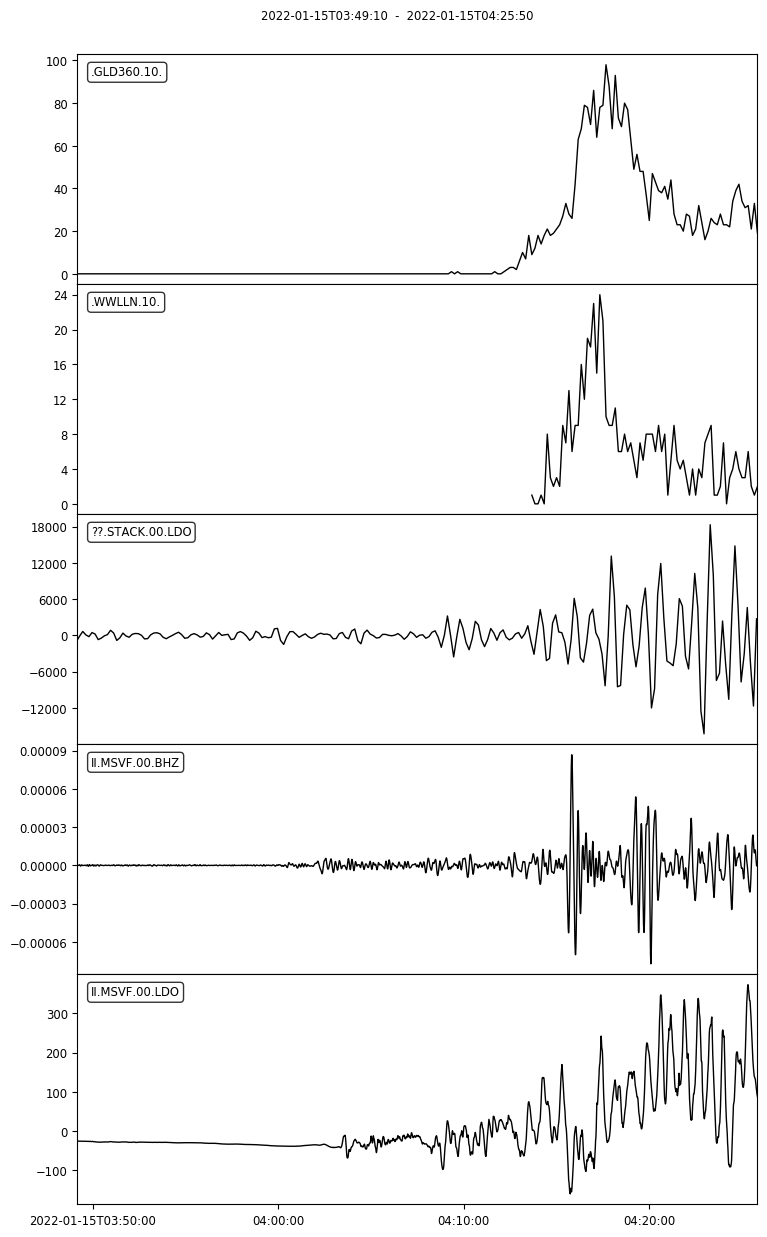

In [235]:
seismoacoustic = obspy.read('seismoacoustic_main_event.mseed')
for tr in seismoacoustic:
    st.append(tr)
st.plot(equal_scale=False, starttime=stime+1150, endtime=etime-250);

In [206]:
gld360f = gld360df.loc[(gld360df['datetime'] >= '2022-01-15 04:00:00') & (gld360df['datetime'] < '2022-01-15 05:00:00')]
gld360f.head(200)

,time,longitude,latitude,signalStrengthKA,cloud,distanceM,datetime,ones,weightedCurrent
329433,2022-01-15T04:09:24.700Z,-175.4219,-20.6038,11.7,True,8608,2022-01-15 04:09:24.700,1.0,0.001359
329434,2022-01-15T04:09:49.213Z,-175.3933,-20.5441,10.0,True,1482,2022-01-15 04:09:49.213,1.0,0.006748
329435,2022-01-15T04:11:48.590Z,-175.3893,-20.5446,17.4,True,1222,2022-01-15 04:11:48.590,1.0,0.014239
329436,2022-01-15T04:12:19.789Z,-175.3980,-20.5477,3.9,True,2114,2022-01-15 04:12:19.789,1.0,0.001845
329437,2022-01-15T04:12:20.002Z,-175.3969,-20.5658,-4.0,False,3659,2022-01-15 04:12:20.002,1.0,-0.001093
...,...,...,...,...,...,...,...,...,...
329628,2022-01-15T04:14:48.190Z,-175.4133,-20.5287,5.3,True,3359,2022-01-15 04:14:48.190,1.0,0.001578
329629,2022-01-15T04:14:49.468Z,-175.4448,-20.5646,37.2,False,7271,2022-01-15 04:14:49.468,1.0,0.005116
329630,2022-01-15T04:14:49.503Z,-175.4140,-20.5549,-4.8,False,3939,2022-01-15 04:14:49.503,1.0,-0.001219
329631,2022-01-15T04:14:50.844Z,-175.4020,-20.5324,-19.7,False,2121,2022-01-15 04:14:50.844,1.0,-0.009288


In [207]:
gld360f.tail(200)

,time,longitude,latitude,signalStrengthKA,cloud,distanceM,datetime,ones,weightedCurrent
452780,2022-01-15T04:59:57.716Z,-175.7072,-19.5395,-77.4,False,115896,2022-01-15 04:59:57.716,1.0,-0.000668
452781,2022-01-15T04:59:57.717Z,-176.0447,-21.2129,-89.4,False,102009,2022-01-15 04:59:57.717,1.0,-0.000876
452782,2022-01-15T04:59:57.723Z,-175.7297,-21.0223,-54.9,False,65044,2022-01-15 04:59:57.723,1.0,-0.000844
452783,2022-01-15T04:59:57.735Z,-174.4009,-21.3134,-81.8,False,133625,2022-01-15 04:59:57.735,1.0,-0.000612
452784,2022-01-15T04:59:57.738Z,-176.0204,-20.2218,-82.8,False,75158,2022-01-15 04:59:57.738,1.0,-0.001102
...,...,...,...,...,...,...,...,...,...
452975,2022-01-15T04:59:59.941Z,-176.1171,-19.9373,-44.9,False,101557,2022-01-15 04:59:59.941,1.0,-0.000442
452976,2022-01-15T04:59:59.945Z,-175.0969,-20.9903,95.1,False,58571,2022-01-15 04:59:59.945,1.0,0.001624
452977,2022-01-15T04:59:59.961Z,-175.8696,-20.5404,123.6,False,50775,2022-01-15 04:59:59.961,1.0,0.002434
452978,2022-01-15T04:59:59.975Z,-174.7749,-20.7582,137.3,False,67830,2022-01-15 04:59:59.975,1.0,0.002024
